In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
from sympy import *
from tqdm import tqdm
from integrator_functions import euler_integrator_step, vel_verlet_integrator_step, leap_frog_integrator_step, acf
import scipy.special
import matplotlib.cm as cm

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Heavy particle in a heat bath

Considera heavy particle $\lbrace Q, \, P, \, M \rbrace$, where $Q$ denotes the position, $P$ the momentum and $M$ the mass, in contact with a heat bath consisting of $N$ coupled oscillators $\lbrace q_i, \, p_i, \, m_i \rbrace$.

The hamiltonian of the system is

\begin{equation}
H = \frac{P^2}{2M} + \sum_{i=1}^N \frac{p_i^2}{2m_i} + V(Q) + \frac{1}{2 }  \sum_{i=1}^N k_i \,  (q_i - Q)^2
\end{equation}

The equations of motion of the heavy particle are 

\begin{equation}
\begin{cases}
\dot{Q} &= \frac{P}{M} \\
\dot{P} &= -\nabla V(Q) - \sum_{i=1}^N k_i \, (Q - q_i)\\
\end{cases} \, .
\end{equation}

The equations of motion of the $N$ lights particles of the heat bath are 

\begin{equation}
\begin{cases}
\dot{q_i} &= \frac{p_i}{m_i} \\
\dot{p_i} &= k_i \, (Q - q_i)\\
\end{cases} \, .
\end{equation}

# Initial positions and momenta of the oscillators

We draw the initial positions and the initial momenta from the Boltzmann distributions:

$$
\pi_q (q_i) = \frac{1}{Z_q} \exp\left( - \beta \frac{k_i}{2}(q_i - Q(0))^2 \right) \,; \quad\quad \pi_p (p_i) = \frac{1}{Z_p} \exp\left( - \beta \frac{p_i^2}{2m_i}\right) \, .
$$

Comparing with the Gaussian function

$$
f(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -  \frac{1}{2}\frac{(x - x(0))^2}{\sigma^2} \right) \, ,
$$

we obtain that the initial positions and momenta can be estimated as

$$
q_i(0) = Q(0) + \xi_i \sqrt{\frac{1}{\beta k_i}} \\
p_i(0) = \eta_i \sqrt{\frac{m_i}{\beta}} \, ,
$$

with $\xi, \eta_i \in \mathcal{N}(0,1)$.

## Integrator setup, system parameters, position discretization

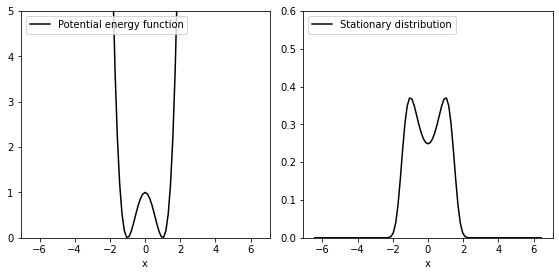

In [2]:
#integrator = 'Euler'
#integrator = 'velocity_verlet'
integrator = 'leap_frog'

# Number of timesteps
Nsteps = 400000

# Integration timestep
dt = 0.02

x = symbols('x')

# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
beta  = 1 / kB / T  # kJ-1 mol
M     = 1           # amu

# Potential energy function kJ mol-1
V     = (x**2 - 1)**2
#V     = x**2

der_V = V.diff(x)
V     = lambdify((x), V, modules=['numpy'])
der_V = lambdify((x), der_V, modules=['numpy'])

# Q-Grid
xmin  = -6.5
xmax  = - xmin
xbins = 100
xedges = np.linspace(xmin,xmax,xbins)
dx = xedges[1] - xedges[0]
xcenters = xedges + 0.5* dx
xcenters = np.delete(xcenters,-1)
xbins = len(xcenters)

stat_distr = np.exp(-beta * V(xcenters)) / np.sum(np.exp(-beta * V(xcenters)) * dx)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20*in2cm, 10*in2cm))  

ax1.plot(xcenters, V(xcenters), 'k-',label='Potential energy function')
ax1.legend(loc='upper left')
ax1.set_xlabel('x');
ax1.set_ylim((0,5))
ax2.plot(xcenters, stat_distr, 'k-',label='Stationary distribution')
ax2.set_xlabel('x');
ax2.legend(loc='upper left')
ax2.set_ylim((0,0.6))
fig.tight_layout()


# Initial frequencies, spring constants and masses of the oscillators

The $i$th particle, with mass $m_i$ and spring constant $k_i$, oscillates with frequency

$$
\omega_i = \sqrt{\frac{k_i}{m_i}} \, .
$$

The frequencies are drawn from a uniform distribution:

$$
\omega_i = N^a \nu_i\,; \quad \nu_i \in \mathcal{U}(0,1)\,; \quad a \in[0,1]
$$

The spring constants are written as

$$
k_i = f^2(\omega_i) \Delta \omega \, , 
$$

where 

$$
\Delta \omega = \frac{N^a}{N} \,,
$$

and

$$
f(\omega_i) = \sqrt{\frac{2}{\pi} \frac{1}{1 + \omega^2}} \, .
$$

In [3]:
# Number of oscillators
N     = 2000

#####################################################
############# case 1
#####################################################

omega1    = np.ones(N)
m1        = M * np.ones(N) / 100
k_spring1 = omega1**2 * m1



#####################################################
############# case 2
#####################################################



omega2    = np.linspace(1, 12.5, N)
m2        = M * np.ones(N) / 100
k_spring2 = omega2 **2 * m1


#####################################################
############# case 3
#####################################################



gamma   = 1
a      = 0.333333

deltaw = N**a / N

alpha   = 10
barbeta = (alpha * gamma)**-1

def f2(omega):
    return 2*alpha / (np.pi*barbeta) * 1 / ( alpha**2  + omega ** 2)


omega3    = np.random.uniform(0,1,N) * N ** a
k_spring3 = f2(omega3) * N**a / N
m3        = k_spring3 / omega3 ** 2

In [4]:
# Trajectoryes arrays
Q1 = np.zeros((Nsteps))
q1 = np.zeros(N)
P1 = np.zeros((Nsteps))
p1 = np.zeros(N)

Q2 = np.zeros((Nsteps))
q2 = np.zeros(N)
P2 = np.zeros((Nsteps))
p2 = np.zeros(N)

Q3 = np.zeros((Nsteps))
q3 = np.zeros(N)
P3 = np.zeros((Nsteps))
p3 = np.zeros(N)


# Initial position heavy particle
Q0    = -1
Q1[0] = Q0
Q2[0] = Q0
Q3[0] = Q0

#Draw initial positions of oscillators from Boltzmann distribution:
q1 = Q0 + np.random.normal(0, 1, N) * np.sqrt( 1 / beta / k_spring1 )
q2 = Q0 + np.random.normal(0, 1, N) * np.sqrt( 1 / beta / k_spring2 )
q3 = Q0 + np.random.normal(0, 1, N) * np.sqrt( 1 / beta / k_spring3 )

#Draw initial momentum of heavy particle from Boltzmann distribution:
P1[0] = np.random.normal(0, 1) * np.sqrt( M / beta )
P2[0] = np.random.normal(0, 1) * np.sqrt( M / beta )
P3[0] = np.random.normal(0, 1) * np.sqrt( M / beta )

#Draw initial momenta of oscillators from Boltzmann distribution:
p1 = np.random.normal(0, 1, N) * np.sqrt(m1 / beta )
p2 = np.random.normal(0, 1, N) * np.sqrt(m2 / beta )#
p3 = np.random.normal(0, 1, N) * np.sqrt(m3 / beta )
#p3 = np.random.uniform(-0.2, 0.2, N) 


for k in tqdm(range(Nsteps-1)):
    if integrator == 'Euler':
        Q1[k+1], q1, P1[k+1], p1 = euler_integrator_step(Q1[k], q1, P1[k], p1, M, m1, der_V, k_spring1, dt)
        Q2[k+1], q2, P2[k+1], p2 = euler_integrator_step(Q2[k], q2, P2[k], p2, M, m2, der_V, k_spring2, dt)
        Q3[k+1], q3, P3[k+1], p3 = euler_integrator_step(Q3[k], q3, P3[k], p3, M, m3, der_V, k_spring3, dt)
        
    elif integrator =='velocity_verlet':
        Q1[k+1], q1, P1[k+1], p1 = vel_verlet_integrator_step(Q1[k], q1, P1[k], p1, M, m1, der_V, k_spring1, dt)
        Q2[k+1], q2, P2[k+1], p2 = vel_verlet_integrator_step(Q2[k], q2, P2[k], p2, M, m2, der_V, k_spring2, dt)
        Q3[k+1], q3, P3[k+1], p3 = vel_verlet_integrator_step(Q3[k], q3, P3[k], p3, M, m3, der_V, k_spring3, dt)

    elif integrator =='leap_frog':
        Q1[k+1], q1, P1[k+1], p1 = leap_frog_integrator_step(Q1[k], q1, P1[k], p1, M, m1, der_V, k_spring1, dt)
        Q2[k+1], q2, P2[k+1], p2 = leap_frog_integrator_step(Q2[k], q2, P2[k], p2, M, m2, der_V, k_spring2, dt)
        Q3[k+1], q3, P3[k+1], p3 = leap_frog_integrator_step(Q3[k], q3, P3[k], p3, M, m3, der_V, k_spring3, dt)


# Build histogram
h  = np.histogram(Q1, bins=xedges, density=True)
h1 = h[0]

h  = np.histogram(Q2, bins=xedges, density=True)
h2 = h[0]

h  = np.histogram(Q3, bins=xedges, density=True)
h3 = h[0]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399999/399999 [00:45<00:00, 8773.39it/s]


In [9]:
# FIGURES 
# 1D grid for position axis
rmin     = - 4
rmax     = - rmin
rbins    = 200
redges   = np.linspace(rmin, rmax, rbins)
dr       = redges[1] - redges[0]
rcenters = redges + 0.5* dr
rcenters = np.delete(rcenters, -1)
rbins    = len(rcenters)

# 1D grid for momentum axis
pmin     = - 4
pmax     = - pmin
pbins    = 200
pedges   = np.linspace(pmin, pmax, pbins)
dp       = pedges[1] - pedges[0]
pcenters = pedges + 0.5 * dp
pcenters = np.delete(pcenters, -1)
pbins    = len(pcenters)

# 2D grid for 2D histograms
grid     = np.meshgrid(rcenters, pcenters)
rgrid    = grid[0]
pgrid    = grid[1]

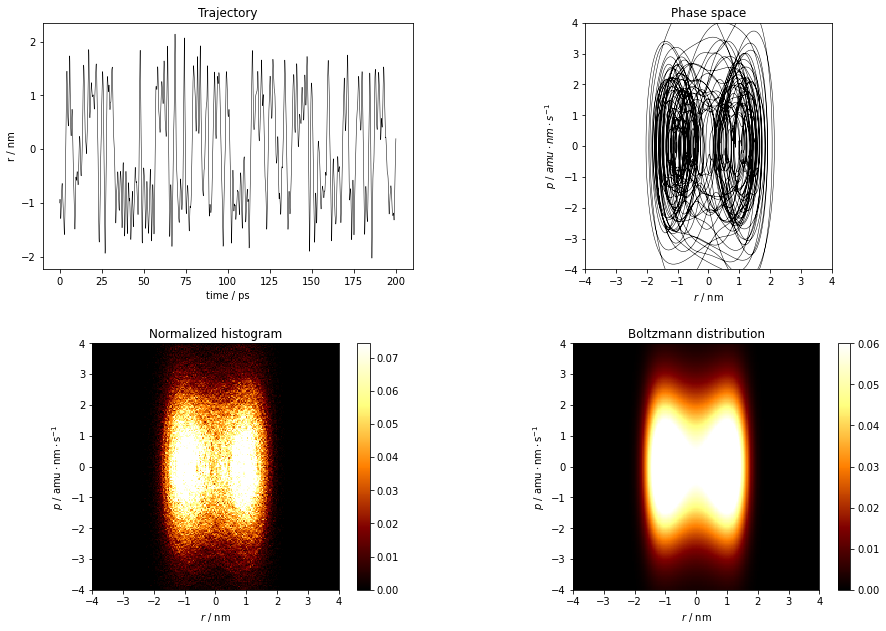

In [10]:
qq =Q3.copy()
pp =P3.copy()



# Build histogram of position and momenta
hist  = np.histogram2d(qq, pp, bins=[redges, pedges], density=True)[0]
row_norms_l1 = np.linalg.norm(hist, ord=1, axis=1, keepdims=True)
#hist  = hist / row_norms_l1

# Boltzmann distribution
pi = np.exp( - beta * V(rgrid) ) * np.exp( - beta * pgrid ** 2 / (2 * M) )

# Normalize Boltzmann distribution
pi = pi / np.sum( pi * dr * dp )

# Time intervals
tvalues = np.linspace(0, Nsteps-1, Nsteps) * dt

fig, ax = plt.subplots(2, 2,figsize=(30*in2cm, 20*in2cm))  

ax[0,0].plot(tvalues[0:10000], qq[0:10000],'k-', linewidth = 0.5, label = r'$r(t)$')
ax[0,0].set_xlabel('time / ps')
ax[0,0].set_ylabel('r / nm')
ax[0,0].set_title('Trajectory')

ax[0,1].plot(qq[0:10000], pp[0:10000], 'k-', linewidth = 0.5, label = r'$\lbrace r(t), p(t)\rbrace$')
ax[0,1].set_xlabel(r'$r$ / nm')
ax[0,1].set_ylabel(r'$p$ / $amu\cdot nm \cdot s^{-1}$')
ax[0,1].set_title('Phase space')
ax[0,1].set_xlim((rmin, rmax))
ax[0,1].set_ylim((pmin, pmax))
ax[0,1].set_aspect('equal')

pos = ax[1,0].pcolormesh(rgrid, pgrid, hist.T,  cmap = cm.afmhot, vmin=0, vmax=0.5*np.maximum(np.max(pi), np.max(hist)))
ax[1,0].set_title('Normalized histogram')
ax[1,0].set_xlabel(r'$r$ / nm')
ax[1,0].set_ylabel(r'$p$ / $\mathrm{amu\cdot nm \cdot s^{-1}}$')
ax[1,0].set_xlim((rmin, rmax))
ax[1,0].set_ylim((pmin, pmax))
ax[1,0].set_aspect('equal')
fig.colorbar(pos, ax=ax[1,0])

pos = ax[1,1].pcolormesh(rgrid, pgrid, pi, cmap = cm.afmhot, vmin=0, vmax=0.06)
ax[1,1].set_title('Boltzmann distribution')
ax[1,1].set_xlabel(r'$r$ / nm')
ax[1,1].set_ylabel(r'$p$ / $\mathrm{amu\cdot nm \cdot s^{-1}}$')
ax[1,1].set_xlim((rmin, rmax))
ax[1,1].set_ylim((pmin, pmax))
ax[1,1].set_aspect('equal')
fig.colorbar(pos, ax=ax[1,1])



plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3);

#fig.savefig('figures/sim_UL_'+str(N3)+'_gamma_'+str(gamma)+'.png', format='png', dpi=900, bbox_inches='tight')